In [322]:
import geopandas as gpd
import numpy as np
import pandas as pd
from pyproj import Transformer, CRS
from shapely.geometry import Point
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from pandas import DataFrame

## Data wrangling

- field data will be given the prefix `field`
- pre-selected site data will be given the prefix `site`
- merge `field` and `site` data
- remove unwanted columns from the field data
- rename columns to meaningful names
- created smaller database with just average results

In [367]:
# superset of column names
cols = {
    'globalid': ['id', 'Unique Site ID'],
    'Site': ['site', 'Site No'],
    'plot': ['plot', 'Plot No'], 
    'Date': ['date', 'Date'], 
    'Name': ['name', 'Assessor Name'], 
    'Fuel': ['veg_type', 'Vegetation Class'],
    'FireHistor': ['fire_hist', 'Time since Fire (y)'], 
    'latitude': ['lat', 'Latitude (°)'], 
    'longitude': ['lon', 'Longitude (°)'],
    'horaccmete': ['loc_accuracy', 'Location accuracy (m)'],
    'FuelDepth1': ['litter_d_1', 'Litter Depth: Sample 1 (mm)'],
    'Cover1': ['litter_state_1', 'Litter State: Sample 1 (presence/absence)'], 
    'NearSurfac': ['ns_h_1', 'Near surface fuel height: Sample 1 (m)'],
    'NearSurf_1': ['ns_state_1', 'Near surface fuel state: Sample 1 (absent/alive/dead)'],
    'Elevated1': ['elev_h_1', 'Elevated fuel height: Sample 1 (m)'],
    'ElevatedCo': ['elev_state_1', 'Elevated fuel state: Sample 1 (absent/alive/dead)'],
    'CanopyHeig': ['canopy_h_1', 'Canopy height: Sample 1 (m)'],
    'CanopyCove': ['canopy_cov_1', 'Canopy cover: Sample 1 (%)'],
    'FuelDepth2': ['litter_d_2', 'Litter Depth: Sample 2 (mm)'], 
    'Cover2': ['litter_state_2', 'Litter State: Sample 2 (presence/absence)'],
    'NearSurf_2': ['ns_h_2', 'Near surface fuel height: Sample 2 (m)'], 
    'NearSurf_3': ['ns_state_2', 'Near surface fuel state: Sample 2 (absent/alive/dead)'],
    'Elevated2': ['elev_h_2', 'Elevated fuel height: Sample 2 (m)'],
    'Elevated_1': ['elev_state_2', 'Elevated fuel state: Sample 2 (absent/alive/dead)'],
    'FuelDepth3': ['litter_d_3', 'Litter Depth: Sample 3 (mm)'],
    'Cover3': ['litter_state_3', 'Litter State: Sample 3 (presence/absence)'],
    'NearSurf_4': ['ns_h_3', 'Near surface fuel height: Sample 3 (m)'],
    'NearSurf_5': ['ns_state_3', 'Near surface fuel state: Sample 3 (absent/alive/dead)'],
    'Elevated3': ['elev_h_3', 'Elevated fuel height: Sample 3 (m)'],
    'Elevated_2': ['elev_state_3', 'Elevated fuel state: Sample 3 (absent/alive/dead)'],
    'CanopyHe_1': ['canopy_h_3', 'Canopy height: Sample 3 (m)'],
    'CanopyCo_1': ['canopy_cov_3', 'Canopy cover: Sample 3 (%)'],
    'FuelDepth4': ['litter_d_4', 'Litter Depth: Sample 4 (mm)'],
    'Cover4': ['litter_state_4', 'Litter State: Sample 4 (presence/absence)'],
    'NearSurf_6': ['ns_h_4', 'Near surface fuel height: Sample 4 (m)'],
    'NearSurf_7': ['ns_state_4', 'Near surface fuel state: Sample 4 (absent/alive/dead)'],
    'Elevated4': ['elev_h_4', 'Elevated fuel height: Sample 4 (m)'],
    'Elevated_3': ['elev_state_4', 'Elevated fuel state: Sample 4 (absent/alive/dead)'],
    'FuelDepth5': ['litter_d_5', 'Litter Depth: Sample 5 (mm)'],
    'Cover5': ['litter_state_5', 'Litter State: Sample 5 (presence/absence)'],
    'NearSurf_8': ['ns_h_5', 'Near surface fuel height: Sample 5 (m)'],
    'NearSurf_9': ['ns_state_5', 'Near surface fuel state: Sample 5 (absent/alive/dead)'],
    'Elevated5': ['elev_h_5', 'Elevated fuel height: Sample 5 (m)'],
    'Elevated_4': ['elev_state_5', 'Elevated fuel state: Sample 5 (absent/alive/dead)'],
    'CanopyHe_2': ['canopy_h_5', 'Canopy height: Sample 5 (m)'],
    'CanopyCo_2': ['canopy_cov_5', 'Canopy cover: Sample 5 (%)'],
    'FuelDepth6': ['litter_d_6', 'Litter Depth: Sample 6 (mm)'],
    'Cover6': ['litter_state_6', 'Litter State: Sample 6 (presence/absence)'],
    'NearSur_10': ['ns_h_6', 'Near surface fuel height: Sample 6 (m)'],
    'NearSur_11': ['ns_state_6', 'Near surface fuel state: Sample 6 (absent/alive/dead)'],
    'Elevated6': ['elev_h_6', 'Elevated fuel height: Sample 6 (m)'],
    'Elevated_5':['elev_state_6', 'Elevated fuel state: Sample 6 (absent/alive/dead)'],
    'FuelDepth7': ['litter_d_7', 'Litter Depth: Sample 7 (mm)'],
    'Cover7': ['litter_state_7', 'Litter State: Sample 7 (presence/absence)'],
    'NearSur_12': ['ns_h_7', 'Near surface fuel height: Sample 7 (m)'],
    'NearSur_13': ['ns_state_7', 'Near surface fuel state: Sample 7 (absent/alive/dead)'],
    'Elevated7': ['elev_h_7', 'Elevated fuel height: Sample 7 (m)'],
    'Elevated_6': ['elev_state_7', 'Elevated fuel state: Sample 7 (absent/alive/dead)'],
    'CanopyHe_3': ['canopy_h_7', 'Canopy height: Sample 7 (m)'],
    'CanopyCo_3': ['canopy_cov_7', 'Canopy cover: Sample 7 (%)'],
    'FuelDepth8': ['litter_d_8', 'Litter Depth: Sample 8 (mm)'], 
    'Cover8': ['litter_state_8', 'Litter State: Sample 8 (presence/absence)'],
    'NearSur_14': ['ns_h_8', 'Near surface fuel height: Sample 8 (m)'],
    'NearSur_15': ['ns_state_8', 'Near surface fuel state: Sample 8 (absent/alive/dead)'],
    'Elevated8': ['elev_h_8', 'Elevated fuel height: Sample 8 (m)'],
    'Elevated_7': ['elev_state_8', 'Elevated fuel state: Sample 8 (absent/alive/dead)'],
    'FuelDepth9': ['litter_d_9', 'Litter Depth: Sample 9 (mm)'],
    'Cover9': ['litter_state_9', 'Litter State: Sample 9 (presence/absence)'],
    'NearSur_16': ['ns_h_9', 'Near surface fuel height: Sample 9 (m)'],
    'NearSur_17': ['ns_state_9', 'Near surface fuel state: Sample 9 (absent/alive/dead)'],
    'Elevated9': ['elev_h_9', 'Elevated fuel height: Sample 9 (m)'],
    'Elevated_8': ['elev_state_9', 'Elevated fuel state: Sample 9 (absent/alive/dead)'],
    'CanopyHe_4': ['canopy_h_9', 'Canopy height: Sample 9 (m)'],
    'CanopyCo_4': ['canopy_cov_9', 'Canopy cover: Sample 9 (%)'],
    'FuelDept_1': ['litter_d_10', 'Litter Depth: Sample 10 (mm)'],
    'Cover10': ['litter_state_10', 'Litter State: Sample 10 (presence/absence)'],
    'NearSur_18': ['ns_h_10', 'Near surface fuel height: Sample 10 (m)'],
    'NearSur_19': ['ns_state_10', 'Near surface fuel state: Sample 10 (absent/alive/dead)'],
    'Elevated10': ['elev_h_10', 'Elevated fuel height: Sample 10 (m)'],
    'Elevated_9': ['elev_state_10', 'Elevated fuel state: Sample 10 (absent/alive/dead)'],
    'AverageFue': ['litter_d_m', 'Mean litter depth (mm)'],
    'AverageSur': ['litter_cov_count', 'Litter cover P/A count (/10)'],
    'AveragePer': ['litter_cov', 'Litter cover (%)'],
    'FuelLoad': ['litter_load', 'Litter fuel load (t/ha)'],
    'Fuel_Hazar': ['s_fhr', 'Surface fuel hazard rating'], 
    'averageNSh': ['ns_h_m', 'Mean near surface height (m)'], 
    'averageNSc': ['ns_state_count', 'Near Surface P/A count (/10)'], 
    'averageN_1': ['ns_cov', 'Near surface cover (%)'], 
    'averageNSd': ['ns_dead_count', 'Near surface dead count'], 
    'percentage': ['ns_dead_%', 'Near surface dead as percentage of near surface present'], 
    'nearsur_20': ['_ns_fhr', 'Near surface Fuel Hazard Rating'], # repeat?
    'Near_Surfa': ['ns_fhr', 'Near surface Fuel Hazard Rating'], 
    'nearsur_21': ['ns_load', 'Near surface fuel load (t/ha)'], 
    'combined': ['s&ns_fhr', 'Combined surface and near surface Fuel Hazard Rating'], 
    'averageele': ['elev_h_m', 'Mean elevated height (m)'], 
    'averagee_1': ['elev_state_count', 'Elevated P/A count (/10)'], 
    'averagee_2': ['elev_cov', 'elevated cover (%)'], 
    'averagee_3': ['elev_dead_count', 'Elevated dead count'],
    'elevatedpe': ['elev_dead_%', 'elevated dead as percentage of elevated present'], 
    'elevated_f': ['_elev_fhr', 'Elevated Fuel Hazard Rating'], # repeat?
    'elevated_h': ['elev_fhr', 'Elevated Fuel Hazard Rating'], 
    'elevate_10': ['elev_load', 'Elevated fuel load (t/ha)'], 
    'bark_type': ['bark_type', 'Bark type'], 
    'bark_fuel': ['bark_haz&type', 'Bark hazard rating and type'], 
    'bark_hazar': ['bark_haz', 'Bark hazard rating'], 
    'bark_fuell': ['bark_load', 'Bark fuel load (t/ha)'], 
    'height_ave': ['canopy_h_m', 'Mean canopy height (m)'], 
    'cannopy_av':['canopy_cov_m', 'Mean canopy cover (%)'], 
    'plotgood': ['representative', 'Plot is representative of area (Y/N)'], 
    'comments': ['comments', 'Comments'],
    'geometry': ['geometry', 'Shapefile geometry'],
}

#AFO layer names and descriptions
afo = {
    'afo_cc': 'AFO Crown Cover %',
    'afo_lfd': 'AFO Ladder Fuel Density',
    'afo_ch': 'AFO Canopy Height (m)',
    'afo_cbh': 'AFO Canopy Base Height (m)',
    'afo_litter': 'AFO litter fuel load (t/ha)', 
    'afo_surface': 'AFO surface fuel load (t/ha)', 
    'afo_elevated': 'AFO elevated fuel  load (t/ha)', 
    'afo_bark': 'AFO bark fuel load (t/ha)'
}

#smaller working set of data - extraneous columns removed
subset = [
    'id', 'site', 'plot', 'veg_type', 'fire_hist', 'loc_accuracy', 
    'litter_d_m', 'litter_cov', 'litter_load', 's_fhr', 
    'ns_h_m', 'ns_cov', 'ns_fhr', 'ns_load', 
    's&ns_fhr', 
    'elev_h_m', 'elev_cov', 'elev_fhr', 'elev_load', 
    'bark_type', 'bark_haz', 'bark_load', 
    'canopy_h_m', 'canopy_cov_m', 
    'representative', 'comments', 'geometry'
]

# useful functions
def reg_plot(x: str, y: str, df: DataFrame) -> ax:
    _df = df[[x, y]].dropna()
    slope, intercept, r_value, p_value, std_err = linregress(_df[x], _df[y], )
    print(f'{afo[x]} v {labels[y]}')
    print(f'stats:')
    print(f'pearson r: {r_value:.2f} \t r sq: {r_value**2:.2f} \t p: {p_value:.2f}')
    ax = sns.lmplot(x=x, y=y, data=df, height=8, aspect=1.5)
    ax.set(xlabel=afo[x], ylabel=labels[y])
    return ax

def reg_plots(x: str, y: str, df: DataFrame, hue: str='region') -> sns.FacetGrid:
    """creates a linear regression with axis labels 

    Args:
        x_col (str): df column name for x values
        y_col (str): df column name for y values
        hue (str, optional): df column name to define subsets. Defaults to 'region'.
    """
    regressions = sns.FacetGrid(df, col=hue, hue=hue, height=5, aspect=1.2, col_wrap=2)
    regressions.map(sns.regplot, x, y)
    regressions.set_ylabels(labels[y])
    regressions.set_xlabels(afo[x])
    
    subsets = set(df[hue])
    for r in subsets:
        _df = df.loc[df[hue]==r]
        _df = _df[[x, y]].dropna()
        if _df.shape[0] > 5: # make sure _df not too small
            slope, intercept, r_value, p_value, std_err = linregress(_df[x], _df[y], )
            print(f'{r} stats:')
            print(f'pearson r: {r_value:.2f} \t r sq: {r_value**2:.2f} \t p: {p_value:.2f}')

    return regressions

In [368]:
field_gdf = gpd.read_file('spatial_data/Field_Data/Fuel_Sampling___Version_0_1.shp')
site_gdf = gpd.read_file('spatial_data/Sample_Points.shp')

cut down the number of columns and rename them to something meaningful (associated with longer description in dictionary)

In [369]:
rename_dict = {} # used to cut down and rename columns
labels = {} # used to label graph axes
for key, [field, desc] in cols.items():
    rename_dict[key] = field
    labels[field] = desc

field_gdf = field_gdf.rename(columns=rename_dict)
field_gdf = field_gdf[subset]
field_gdf.head()

,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,elev_fhr,elev_load,bark_type,bark_haz,bark_load,canopy_h_m,canopy_cov_m,representative,comments,geometry
0,d1a280cb-06c0-43ac-a81f-ef7a9f273c9e,EC13,1,DSF,None,4.663372,52,100,25,Extreme,...,High,2,Coarsely,Moderate,0,9.8,62,yes,None,POINT (150.99193 -34.12544)
1,920f1476-65e4-414d-94c6-e0680b293a5e,EC9,1,Heath,8+,28.633412,23,90,10,High,...,Extreme,10,Slab,Low,0,3.8,24,yes,None,POINT (151.26901 -33.60947)
2,d191484d-8f6a-420c-bd1b-69b4597b2ac5,EC13,2,DSF,None,4.600974,35,100,15,Very High,...,Moderate,0,Coarsely,Low,0,None,52,yes,None,POINT (150.99142 -34.12567)
3,757bfc31-be8d-4ecb-b07b-42a99b9fbe58,EC48,1,None,None,4.219000,47,90,20,Extreme,...,Extreme,10,Coarsely,High,2,10.2,None,yes,None,POINT (150.91926 -34.23753)
4,4ab4d4a4-a7fc-4282-8371-0f8fffe2d46b,EC9,2,Heath,8+,0.000000,15,100,5,Moderate,...,Very High,6,Coarsely,Low,0,4,28,yes,None,POINT (151.25154 -33.62291)


shapefile fields are imported as objects so need to convert ot data types that can be used for correlation and other analyses

In [370]:
field_gdf= field_gdf.replace('BlanK', np.nan) # some missing values

numeric = [
    'litter_d_m', 'litter_cov', 'litter_load', 
    'ns_h_m', 'ns_cov', 'ns_load', 
    'elev_h_m', 'elev_cov', 'elev_load', 
    'bark_load', 
    'canopy_h_m', 'canopy_cov_m', 
]

for col in numeric:
    field_gdf[col] = pd.to_numeric(field_gdf[col])
# field_gdf.dtypes

In [371]:
# add region identifier
field_gdf['region'] = np.where(
    field_gdf['site'].str.startswith('EC'), 'central',
        np.where(field_gdf['site'].str.startswith('P'), 'pilliga', 
            np.where(field_gdf['site'].str.startswith('SM'),'snowy', 'other')
    )
)
field_gdf.head()

,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,elev_load,bark_type,bark_haz,bark_load,canopy_h_m,canopy_cov_m,representative,comments,geometry,region
0,d1a280cb-06c0-43ac-a81f-ef7a9f273c9e,EC13,1,DSF,None,4.663372,52.0,100,25.0,Extreme,...,2,Coarsely,Moderate,0,9.8,62.0,yes,None,POINT (150.99193 -34.12544),central
1,920f1476-65e4-414d-94c6-e0680b293a5e,EC9,1,Heath,8+,28.633412,23.0,90,10.0,High,...,10,Slab,Low,0,3.8,24.0,yes,None,POINT (151.26901 -33.60947),central
2,d191484d-8f6a-420c-bd1b-69b4597b2ac5,EC13,2,DSF,None,4.600974,35.0,100,15.0,Very High,...,0,Coarsely,Low,0,NaN,52.0,yes,None,POINT (150.99142 -34.12567),central
3,757bfc31-be8d-4ecb-b07b-42a99b9fbe58,EC48,1,None,None,4.219000,47.0,90,20.0,Extreme,...,10,Coarsely,High,2,10.2,NaN,yes,None,POINT (150.91926 -34.23753),central
4,4ab4d4a4-a7fc-4282-8371-0f8fffe2d46b,EC9,2,Heath,8+,0.000000,15.0,100,5.0,Moderate,...,6,Coarsely,Low,0,4.0,28.0,yes,None,POINT (151.25154 -33.62291),central


Use the MGA coordinates to determine how far the field sample was from the pre-determined site. First need to determine MGA Zones then transform with appropriate CRS for each Zone.

In [372]:
for g in [site_gdf, field_gdf]:
    zone = 56
    g['zone'] = zone
    for lon in range(156, 108, -6):
        g['zone'] = g['zone'].where(g['geometry'].x > lon, zone)
        zone -= 1

for g in [site_gdf, field_gdf]:
    # g['loc_cartesian'] = g['geometry']
    g['loc_cartesian'] = Point(-9999, -9999)
    for zone in range(56,53,-1):
        _g = g.to_crs(28300+zone)
        g['loc_cartesian'] = _g['geometry'].where(g['zone']==zone, g['loc_cartesian'])

field_gdf.head()

,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,bark_haz,bark_load,canopy_h_m,canopy_cov_m,representative,comments,geometry,region,zone,loc_cartesian
0,d1a280cb-06c0-43ac-a81f-ef7a9f273c9e,EC13,1,DSF,None,4.663372,52.0,100,25.0,Extreme,...,Moderate,0,9.8,62.0,yes,None,POINT (150.99193 -34.12544),central,56,POINT (314817.129 6222113.282)
1,920f1476-65e4-414d-94c6-e0680b293a5e,EC9,1,Heath,8+,28.633412,23.0,90,10.0,High,...,Low,0,3.8,24.0,yes,None,POINT (151.26901 -33.60947),central,56,POINT (339408.654 6279799.350)
2,d191484d-8f6a-420c-bd1b-69b4597b2ac5,EC13,2,DSF,None,4.600974,35.0,100,15.0,Very High,...,Low,0,NaN,52.0,yes,None,POINT (150.99142 -34.12567),central,56,POINT (314771.277 6222086.198)
3,757bfc31-be8d-4ecb-b07b-42a99b9fbe58,EC48,1,None,None,4.219000,47.0,90,20.0,Extreme,...,High,2,10.2,NaN,yes,None,POINT (150.91926 -34.23753),central,56,POINT (308368.921 6209547.457)
4,4ab4d4a4-a7fc-4282-8371-0f8fffe2d46b,EC9,2,Heath,8+,0.000000,15.0,100,5.0,Moderate,...,Low,0,4.0,28.0,yes,None,POINT (151.25154 -33.62291),central,56,POINT (337813.177 6278281.595)


In [373]:
site_gdf = site_gdf.rename(columns={'loc_cartesian': 'site_cartesian'})
gdf = field_gdf.merge(site_gdf[['Site_Id', 'site_cartesian']], left_on='site', right_on='Site_Id', how='left')
gdf['dist'] = gdf['loc_cartesian'].distance(gdf['site_cartesian'])
labels['dist'] = 'Distance between designated site and actual sample location (m)'
gdf.head()
gdf.shape

(143, 33)

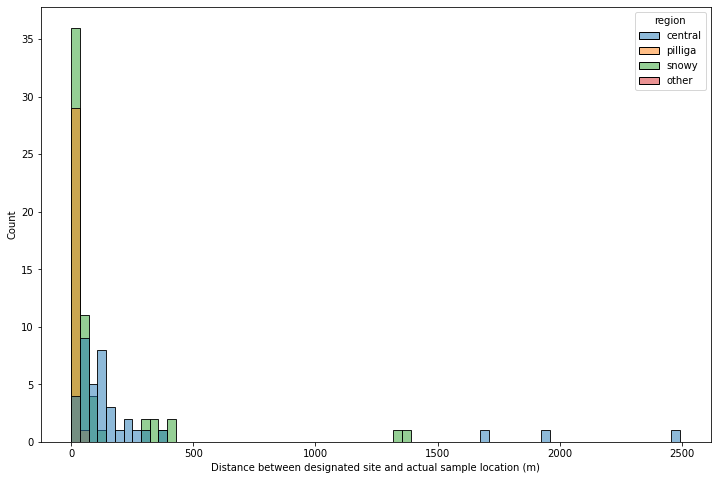

In [374]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
x_col = 'dist'
ax = sns.histplot(x=x_col, data=gdf, hue='region')
ax.set(xlabel=labels[x_col])
plt.show()

In [375]:
gdf['dist'].median()

27.053009808444642

## Sample the AFO geotiffs

In [376]:
gdf_z56 = gdf.to_crs('EPSG:32756') #convert to MGA Zone 56 because that is what the geotifs are
gdf_z56.head()

,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,canopy_cov_m,representative,comments,geometry,region,zone,loc_cartesian,Site_Id,site_cartesian,dist
0,d1a280cb-06c0-43ac-a81f-ef7a9f273c9e,EC13,1,DSF,None,4.663372,52.0,100,25.0,Extreme,...,62.0,yes,None,POINT (314817.602 6222114.701),central,56,POINT (314817.129 6222113.282),EC13,POINT (314767.591 6222035.456),92.255108
1,920f1476-65e4-414d-94c6-e0680b293a5e,EC9,1,Heath,8+,28.633412,23.0,90,10.0,High,...,24.0,yes,None,POINT (339409.137 6279800.765),central,56,POINT (339408.654 6279799.350),EC9,POINT (339429.874 6280179.659),380.900358
2,d191484d-8f6a-420c-bd1b-69b4597b2ac5,EC13,2,DSF,None,4.600974,35.0,100,15.0,Very High,...,52.0,yes,None,POINT (314771.749 6222087.616),central,56,POINT (314771.277 6222086.198),EC13,POINT (314767.591 6222035.456),50.875830
3,757bfc31-be8d-4ecb-b07b-42a99b9fbe58,EC48,1,None,None,4.219000,47.0,90,20.0,Extreme,...,NaN,yes,None,POINT (308369.392 6209548.877),central,56,POINT (308368.921 6209547.457),EC48,POINT (307972.150 6207896.071),1698.382466
4,4ab4d4a4-a7fc-4282-8371-0f8fffe2d46b,EC9,2,Heath,8+,0.000000,15.0,100,5.0,Moderate,...,28.0,yes,None,POINT (337813.660 6278283.010),central,56,POINT (337813.177 6278281.595),EC9,POINT (339429.874 6280179.659),2493.261791


In [377]:
site_coords = [(x,y) for x,y in zip(gdf_z56['geometry'].x , gdf_z56['geometry'].y)]

In [378]:
#crown cover
cc_paths = {
    'pilliga': 'spatial_data/Pilliga-vegetation-canopy_cover-2021.tif',
    'central': 'spatial_data/Centralcoast-vegetation-canopy_cover-2021.tif',
    'snowy': 'spatial_data/Southmnts-vegetation-canopy_cover-2021.tif',
}

for loc, path in cc_paths.items():
    with rasterio.open(path, 'r') as src:
        gdf_z56[loc] = -9999
        gdf_z56[loc] = [x for x in src.sample(site_coords)]

gdf_z56['afo_cc'] = gdf_z56[['pilliga', 'central', 'snowy']].max(axis=1)
gdf_z56.head()

,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,region,zone,loc_cartesian,Site_Id,site_cartesian,dist,pilliga,central,snowy,afo_cc
0,d1a280cb-06c0-43ac-a81f-ef7a9f273c9e,EC13,1,DSF,None,4.663372,52.0,100,25.0,Extreme,...,central,56,POINT (314817.129 6222113.282),EC13,POINT (314767.591 6222035.456),92.255108,[-9999.0],[57.428734],[-9999.0],57.428734
1,920f1476-65e4-414d-94c6-e0680b293a5e,EC9,1,Heath,8+,28.633412,23.0,90,10.0,High,...,central,56,POINT (339408.654 6279799.350),EC9,POINT (339429.874 6280179.659),380.900358,[-9999.0],[37.263172],[-9999.0],37.263172
2,d191484d-8f6a-420c-bd1b-69b4597b2ac5,EC13,2,DSF,None,4.600974,35.0,100,15.0,Very High,...,central,56,POINT (314771.277 6222086.198),EC13,POINT (314767.591 6222035.456),50.875830,[-9999.0],[59.812386],[-9999.0],59.812386
3,757bfc31-be8d-4ecb-b07b-42a99b9fbe58,EC48,1,None,None,4.219000,47.0,90,20.0,Extreme,...,central,56,POINT (308368.921 6209547.457),EC48,POINT (307972.150 6207896.071),1698.382466,[-9999.0],[56.73754],[-9999.0],56.737541
4,4ab4d4a4-a7fc-4282-8371-0f8fffe2d46b,EC9,2,Heath,8+,0.000000,15.0,100,5.0,Moderate,...,central,56,POINT (337813.177 6278281.595),EC9,POINT (339429.874 6280179.659),2493.261791,[-9999.0],[77.17865],[-9999.0],77.178650


In [379]:
# ladder fuel density
lfd_paths = {
    'pilliga': 'spatial_data/Pilliga-vegetation-ladder_fuel_density-2021.tif',
    'central': 'spatial_data/Centralcoast-vegetation-ladder_fuel_density-2021.tif',
    'snowy': 'spatial_data/Southmnts-vegetation-ladder_fuel_density-2021.tif',
}
for loc, path in lfd_paths.items():
    with rasterio.open(path, 'r') as src:
        gdf_z56[loc] = -9999
        gdf_z56[loc] = [x for x in src.sample(site_coords)]

gdf_z56['afo_lfd'] = gdf_z56[['pilliga', 'central', 'snowy']].max(axis=1)
gdf_z56.head()

,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,zone,loc_cartesian,Site_Id,site_cartesian,dist,pilliga,central,snowy,afo_cc,afo_lfd
0,d1a280cb-06c0-43ac-a81f-ef7a9f273c9e,EC13,1,DSF,None,4.663372,52.0,100,25.0,Extreme,...,56,POINT (314817.129 6222113.282),EC13,POINT (314767.591 6222035.456),92.255108,[-9999.0],[3.0110118],[-9999.0],57.428734,3.011012
1,920f1476-65e4-414d-94c6-e0680b293a5e,EC9,1,Heath,8+,28.633412,23.0,90,10.0,High,...,56,POINT (339408.654 6279799.350),EC9,POINT (339429.874 6280179.659),380.900358,[-9999.0],[10.644293],[-9999.0],37.263172,10.644293
2,d191484d-8f6a-420c-bd1b-69b4597b2ac5,EC13,2,DSF,None,4.600974,35.0,100,15.0,Very High,...,56,POINT (314771.277 6222086.198),EC13,POINT (314767.591 6222035.456),50.875830,[-9999.0],[3.4744804],[-9999.0],59.812386,3.474480
3,757bfc31-be8d-4ecb-b07b-42a99b9fbe58,EC48,1,None,None,4.219000,47.0,90,20.0,Extreme,...,56,POINT (308368.921 6209547.457),EC48,POINT (307972.150 6207896.071),1698.382466,[-9999.0],[5.395609],[-9999.0],56.737541,5.395609
4,4ab4d4a4-a7fc-4282-8371-0f8fffe2d46b,EC9,2,Heath,8+,0.000000,15.0,100,5.0,Moderate,...,56,POINT (337813.177 6278281.595),EC9,POINT (339429.874 6280179.659),2493.261791,[-9999.0],[10.855474],[-9999.0],77.178650,10.855474


In [380]:
# canopy height
ch_paths = {
    'pilliga': 'spatial_data/Pilliga-vegetation-canopy_height-2021.tif',
    'central': 'spatial_data/Centralcoast-vegetation-canopy_height-2021.tif',
    'snowy': 'spatial_data/Southmnts-vegetation-canopy_height-2021.tif',
}
for loc, path in ch_paths.items():
    with rasterio.open(path, 'r') as src:
        gdf_z56[loc] = -9999
        gdf_z56[loc] = [x for x in src.sample(site_coords)]

gdf_z56['afo_ch'] = gdf_z56[['pilliga', 'central', 'snowy']].max(axis=1)
gdf_z56.head()

,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,loc_cartesian,Site_Id,site_cartesian,dist,pilliga,central,snowy,afo_cc,afo_lfd,afo_ch
0,d1a280cb-06c0-43ac-a81f-ef7a9f273c9e,EC13,1,DSF,None,4.663372,52.0,100,25.0,Extreme,...,POINT (314817.129 6222113.282),EC13,POINT (314767.591 6222035.456),92.255108,[-9999.0],[9.554693],[-9999.0],57.428734,3.011012,9.554693
1,920f1476-65e4-414d-94c6-e0680b293a5e,EC9,1,Heath,8+,28.633412,23.0,90,10.0,High,...,POINT (339408.654 6279799.350),EC9,POINT (339429.874 6280179.659),380.900358,[-9999.0],[5.393795],[-9999.0],37.263172,10.644293,5.393795
2,d191484d-8f6a-420c-bd1b-69b4597b2ac5,EC13,2,DSF,None,4.600974,35.0,100,15.0,Very High,...,POINT (314771.277 6222086.198),EC13,POINT (314767.591 6222035.456),50.875830,[-9999.0],[9.485182],[-9999.0],59.812386,3.474480,9.485182
3,757bfc31-be8d-4ecb-b07b-42a99b9fbe58,EC48,1,None,None,4.219000,47.0,90,20.0,Extreme,...,POINT (308368.921 6209547.457),EC48,POINT (307972.150 6207896.071),1698.382466,[-9999.0],[10.259424],[-9999.0],56.737541,5.395609,10.259424
4,4ab4d4a4-a7fc-4282-8371-0f8fffe2d46b,EC9,2,Heath,8+,0.000000,15.0,100,5.0,Moderate,...,POINT (337813.177 6278281.595),EC9,POINT (339429.874 6280179.659),2493.261791,[-9999.0],[4.8907933],[-9999.0],77.178650,10.855474,4.890793


In [382]:
# canopy base height
cbh_paths = {
    'pilliga': 'spatial_data/Pilliga-vegetation-canopy_base_height-2021.tif',
    'central': 'spatial_data/Centralcoast-vegetation-canopy_base_height-2021.tif',
    'snowy': 'spatial_data/Southmnts-vegetation-canopy_base_height-2021.tif',
}
for loc, path in cbh_paths.items():
    with rasterio.open(path, 'r') as src:
        gdf_z56[loc] = -9999
        gdf_z56[loc] = [x for x in src.sample(site_coords)]

gdf_z56['afo_cbh'] = gdf_z56[['pilliga', 'central', 'snowy']].max(axis=1)
gdf_z56.head()

,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,Site_Id,site_cartesian,dist,pilliga,central,snowy,afo_cc,afo_lfd,afo_ch,afo_cbh
0,d1a280cb-06c0-43ac-a81f-ef7a9f273c9e,EC13,1,DSF,None,4.663372,52.0,100,25.0,Extreme,...,EC13,POINT (314767.591 6222035.456),92.255108,[-9999.0],[6.159936],[-9999.0],57.428734,3.011012,9.554693,6.159936
1,920f1476-65e4-414d-94c6-e0680b293a5e,EC9,1,Heath,8+,28.633412,23.0,90,10.0,High,...,EC9,POINT (339429.874 6280179.659),380.900358,[-9999.0],[3.5986915],[-9999.0],37.263172,10.644293,5.393795,3.598691
2,d191484d-8f6a-420c-bd1b-69b4597b2ac5,EC13,2,DSF,None,4.600974,35.0,100,15.0,Very High,...,EC13,POINT (314767.591 6222035.456),50.875830,[-9999.0],[7.107333],[-9999.0],59.812386,3.474480,9.485182,7.107333
3,757bfc31-be8d-4ecb-b07b-42a99b9fbe58,EC48,1,None,None,4.219000,47.0,90,20.0,Extreme,...,EC48,POINT (307972.150 6207896.071),1698.382466,[-9999.0],[6.8266096],[-9999.0],56.737541,5.395609,10.259424,6.826610
4,4ab4d4a4-a7fc-4282-8371-0f8fffe2d46b,EC9,2,Heath,8+,0.000000,15.0,100,5.0,Moderate,...,EC9,POINT (339429.874 6280179.659),2493.261791,[-9999.0],[1.9396412],[-9999.0],77.178650,10.855474,4.890793,1.939641


In [383]:
fuel_load_paths = {
    'pilliga': 'spatial_data/Pilliga-fuels-classes-2021-density.tif',
    'central': 'spatial_data/Centralcoast-fuels-classes-2021-density.tif',
    'snowy': 'spatial_data/Southmnts-fuels-classes-2021-density.tif',
}

strata = ['afo_litter', 'afo_surface', 'afo_elevated', 'afo_bark']

for loc, path in fuel_load_paths.items():
    with rasterio.open(path, 'r') as src:
        # for i, stratum in enumerate(strata):
        gdf_z56[loc] = -9999
        gdf_z56[loc] = [x for x in src.sample(site_coords)]

gdf_z56.head()

,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,Site_Id,site_cartesian,dist,pilliga,central,snowy,afo_cc,afo_lfd,afo_ch,afo_cbh
0,d1a280cb-06c0-43ac-a81f-ef7a9f273c9e,EC13,1,DSF,None,4.663372,52.0,100,25.0,Extreme,...,EC13,POINT (314767.591 6222035.456),92.255108,"[-9999.0, -9999.0, -9999.0, -9999.0]","[14.506964, 16.52059, 6.125993, 2.8971925]","[-9999.0, -9999.0, -9999.0, -9999.0]",57.428734,3.011012,9.554693,6.159936
1,920f1476-65e4-414d-94c6-e0680b293a5e,EC9,1,Heath,8+,28.633412,23.0,90,10.0,High,...,EC9,POINT (339429.874 6280179.659),380.900358,"[-9999.0, -9999.0, -9999.0, -9999.0]","[24.350914, 26.026056, 5.464834, 0.6155899]","[-9999.0, -9999.0, -9999.0, -9999.0]",37.263172,10.644293,5.393795,3.598691
2,d191484d-8f6a-420c-bd1b-69b4597b2ac5,EC13,2,DSF,None,4.600974,35.0,100,15.0,Very High,...,EC13,POINT (314767.591 6222035.456),50.875830,"[-9999.0, -9999.0, -9999.0, -9999.0]","[14.485043, 16.495626, 5.9955134, 2.8354843]","[-9999.0, -9999.0, -9999.0, -9999.0]",59.812386,3.474480,9.485182,7.107333
3,757bfc31-be8d-4ecb-b07b-42a99b9fbe58,EC48,1,None,None,4.219000,47.0,90,20.0,Extreme,...,EC48,POINT (307972.150 6207896.071),1698.382466,"[-9999.0, -9999.0, -9999.0, -9999.0]","[14.335109, 16.324991, 5.3534164, 2.5316808]","[-9999.0, -9999.0, -9999.0, -9999.0]",56.737541,5.395609,10.259424,6.826610
4,4ab4d4a4-a7fc-4282-8371-0f8fffe2d46b,EC9,2,Heath,8+,0.000000,15.0,100,5.0,Moderate,...,EC9,POINT (339429.874 6280179.659),2493.261791,"[-9999.0, -9999.0, -9999.0, -9999.0]","[30.025637, 32.091156, 9.474245, 1.0672326]","[-9999.0, -9999.0, -9999.0, -9999.0]",77.178650,10.855474,4.890793,1.939641


In [384]:
gdf_z56['afo_fuel'] = gdf_z56['pilliga']
gdf_z56['afo_fuel'] = gdf_z56['central'].where(gdf_z56['site'].str.startswith('EC'), gdf_z56['afo_fuel'])
gdf_z56['afo_fuel'] = gdf_z56['snowy'].where(gdf_z56['site'].str.startswith('SM'), gdf_z56['afo_fuel'])
gdf_z56.head()


,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,site_cartesian,dist,pilliga,central,snowy,afo_cc,afo_lfd,afo_ch,afo_cbh,afo_fuel
0,d1a280cb-06c0-43ac-a81f-ef7a9f273c9e,EC13,1,DSF,None,4.663372,52.0,100,25.0,Extreme,...,POINT (314767.591 6222035.456),92.255108,"[-9999.0, -9999.0, -9999.0, -9999.0]","[14.506964, 16.52059, 6.125993, 2.8971925]","[-9999.0, -9999.0, -9999.0, -9999.0]",57.428734,3.011012,9.554693,6.159936,"[14.506964, 16.52059, 6.125993, 2.8971925]"
1,920f1476-65e4-414d-94c6-e0680b293a5e,EC9,1,Heath,8+,28.633412,23.0,90,10.0,High,...,POINT (339429.874 6280179.659),380.900358,"[-9999.0, -9999.0, -9999.0, -9999.0]","[24.350914, 26.026056, 5.464834, 0.6155899]","[-9999.0, -9999.0, -9999.0, -9999.0]",37.263172,10.644293,5.393795,3.598691,"[24.350914, 26.026056, 5.464834, 0.6155899]"
2,d191484d-8f6a-420c-bd1b-69b4597b2ac5,EC13,2,DSF,None,4.600974,35.0,100,15.0,Very High,...,POINT (314767.591 6222035.456),50.875830,"[-9999.0, -9999.0, -9999.0, -9999.0]","[14.485043, 16.495626, 5.9955134, 2.8354843]","[-9999.0, -9999.0, -9999.0, -9999.0]",59.812386,3.474480,9.485182,7.107333,"[14.485043, 16.495626, 5.9955134, 2.8354843]"
3,757bfc31-be8d-4ecb-b07b-42a99b9fbe58,EC48,1,None,None,4.219000,47.0,90,20.0,Extreme,...,POINT (307972.150 6207896.071),1698.382466,"[-9999.0, -9999.0, -9999.0, -9999.0]","[14.335109, 16.324991, 5.3534164, 2.5316808]","[-9999.0, -9999.0, -9999.0, -9999.0]",56.737541,5.395609,10.259424,6.826610,"[14.335109, 16.324991, 5.3534164, 2.5316808]"
4,4ab4d4a4-a7fc-4282-8371-0f8fffe2d46b,EC9,2,Heath,8+,0.000000,15.0,100,5.0,Moderate,...,POINT (339429.874 6280179.659),2493.261791,"[-9999.0, -9999.0, -9999.0, -9999.0]","[30.025637, 32.091156, 9.474245, 1.0672326]","[-9999.0, -9999.0, -9999.0, -9999.0]",77.178650,10.855474,4.890793,1.939641,"[30.025637, 32.091156, 9.474245, 1.0672326]"


In [385]:
strata = ['afo_litter', 'afo_surface', 'afo_elevated', 'afo_bark']
split_fuels = pd.DataFrame(gdf_z56['afo_fuel'].tolist(), columns=strata)
split_fuels.head()

,afo_litter,afo_surface,afo_elevated,afo_bark
0,14.506964,16.520590,6.125993,2.897192
1,24.350914,26.026056,5.464834,0.615590
2,14.485043,16.495626,5.995513,2.835484
3,14.335109,16.324991,5.353416,2.531681
4,30.025637,32.091156,9.474245,1.067233


In [386]:
gdf_z56 = pd.concat([gdf_z56, split_fuels], axis=1)
gdf_z56.head()


,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,snowy,afo_cc,afo_lfd,afo_ch,afo_cbh,afo_fuel,afo_litter,afo_surface,afo_elevated,afo_bark
0,d1a280cb-06c0-43ac-a81f-ef7a9f273c9e,EC13,1,DSF,None,4.663372,52.0,100,25.0,Extreme,...,"[-9999.0, -9999.0, -9999.0, -9999.0]",57.428734,3.011012,9.554693,6.159936,"[14.506964, 16.52059, 6.125993, 2.8971925]",14.506964,16.520590,6.125993,2.897192
1,920f1476-65e4-414d-94c6-e0680b293a5e,EC9,1,Heath,8+,28.633412,23.0,90,10.0,High,...,"[-9999.0, -9999.0, -9999.0, -9999.0]",37.263172,10.644293,5.393795,3.598691,"[24.350914, 26.026056, 5.464834, 0.6155899]",24.350914,26.026056,5.464834,0.615590
2,d191484d-8f6a-420c-bd1b-69b4597b2ac5,EC13,2,DSF,None,4.600974,35.0,100,15.0,Very High,...,"[-9999.0, -9999.0, -9999.0, -9999.0]",59.812386,3.474480,9.485182,7.107333,"[14.485043, 16.495626, 5.9955134, 2.8354843]",14.485043,16.495626,5.995513,2.835484
3,757bfc31-be8d-4ecb-b07b-42a99b9fbe58,EC48,1,None,None,4.219000,47.0,90,20.0,Extreme,...,"[-9999.0, -9999.0, -9999.0, -9999.0]",56.737541,5.395609,10.259424,6.826610,"[14.335109, 16.324991, 5.3534164, 2.5316808]",14.335109,16.324991,5.353416,2.531681
4,4ab4d4a4-a7fc-4282-8371-0f8fffe2d46b,EC9,2,Heath,8+,0.000000,15.0,100,5.0,Moderate,...,"[-9999.0, -9999.0, -9999.0, -9999.0]",77.178650,10.855474,4.890793,1.939641,"[30.025637, 32.091156, 9.474245, 1.0672326]",30.025637,32.091156,9.474245,1.067233


trim the dataframe down again

In [387]:
print(list(gdf_z56.columns.values))

['id', 'site', 'plot', 'veg_type', 'fire_hist', 'loc_accuracy', 'litter_d_m', 'litter_cov', 'litter_load', 's_fhr', 'ns_h_m', 'ns_cov', 'ns_fhr', 'ns_load', 's&ns_fhr', 'elev_h_m', 'elev_cov', 'elev_fhr', 'elev_load', 'bark_type', 'bark_haz', 'bark_load', 'canopy_h_m', 'canopy_cov_m', 'representative', 'comments', 'geometry', 'region', 'zone', 'loc_cartesian', 'Site_Id', 'site_cartesian', 'dist', 'pilliga', 'central', 'snowy', 'afo_cc', 'afo_lfd', 'afo_ch', 'afo_cbh', 'afo_fuel', 'afo_litter', 'afo_surface', 'afo_elevated', 'afo_bark']


In [388]:
gdf_z56 = gdf_z56[[
    'id', 'site', 'plot', 'region', 'geometry', 'veg_type', 'fire_hist', 'loc_accuracy',
    'zone', 'loc_cartesian', 'site_cartesian', 'dist', 
    'litter_d_m', 'litter_cov', 'litter_load', 's_fhr', 
    'ns_h_m', 'ns_cov', 'ns_fhr', 'ns_fhr', 'ns_load', 's&ns_fhr', 
    'elev_h_m', 'elev_cov', 'elev_fhr', 'elev_fhr', 'elev_load', 
    'bark_type', 'bark_haz', 'bark_load', 
    'canopy_h_m', 'canopy_cov_m', 
    'representative', 
    'afo_cc', 'afo_lfd', 'afo_ch', 'afo_cbh', 'afo_litter', 'afo_surface', 'afo_elevated', 'afo_bark'
]]

gdf_z56.head()

,id,site,plot,region,geometry,veg_type,fire_hist,loc_accuracy,zone,loc_cartesian,...,canopy_cov_m,representative,afo_cc,afo_lfd,afo_ch,afo_cbh,afo_litter,afo_surface,afo_elevated,afo_bark
0,d1a280cb-06c0-43ac-a81f-ef7a9f273c9e,EC13,1,central,POINT (314817.602 6222114.701),DSF,None,4.663372,56,POINT (314817.129 6222113.282),...,62.0,yes,57.428734,3.011012,9.554693,6.159936,14.506964,16.520590,6.125993,2.897192
1,920f1476-65e4-414d-94c6-e0680b293a5e,EC9,1,central,POINT (339409.137 6279800.765),Heath,8+,28.633412,56,POINT (339408.654 6279799.350),...,24.0,yes,37.263172,10.644293,5.393795,3.598691,24.350914,26.026056,5.464834,0.615590
2,d191484d-8f6a-420c-bd1b-69b4597b2ac5,EC13,2,central,POINT (314771.749 6222087.616),DSF,None,4.600974,56,POINT (314771.277 6222086.198),...,52.0,yes,59.812386,3.474480,9.485182,7.107333,14.485043,16.495626,5.995513,2.835484
3,757bfc31-be8d-4ecb-b07b-42a99b9fbe58,EC48,1,central,POINT (308369.392 6209548.877),None,None,4.219000,56,POINT (308368.921 6209547.457),...,NaN,yes,56.737541,5.395609,10.259424,6.826610,14.335109,16.324991,5.353416,2.531681
4,4ab4d4a4-a7fc-4282-8371-0f8fffe2d46b,EC9,2,central,POINT (337813.660 6278283.010),Heath,8+,0.000000,56,POINT (337813.177 6278281.595),...,28.0,yes,77.178650,10.855474,4.890793,1.939641,30.025637,32.091156,9.474245,1.067233


In [389]:
df_corr = gdf_z56.corr(method='pearson')
df_corr

,loc_accuracy,zone,dist,litter_d_m,litter_cov,litter_load,ns_h_m,ns_cov,ns_load,elev_h_m,...,canopy_h_m,canopy_cov_m,afo_cc,afo_lfd,afo_ch,afo_cbh,afo_litter,afo_surface,afo_elevated,afo_bark
loc_accuracy,1.000000,-0.088256,-0.051491,0.034442,-0.003259,-0.043230,-0.131079,0.058377,-0.013285,0.078836,...,0.157995,0.124117,-0.026431,0.015386,0.065074,0.013533,0.047642,0.047639,0.047408,0.047454
zone,-0.088256,1.000000,0.253011,0.189397,-0.118092,0.133455,0.345819,-0.144027,0.272451,0.514414,...,-0.610426,0.388532,0.711636,0.024217,0.095001,-0.270761,-0.435251,-0.435107,-0.435314,-0.435649
dist,-0.051491,0.253011,1.000000,-0.026725,0.027321,0.019964,-0.054711,0.126331,0.204388,-0.070056,...,-0.055047,-0.081842,0.151128,0.279586,-0.090190,-0.119182,0.106114,0.121403,0.221254,0.006198
litter_d_m,0.034442,0.189397,-0.026725,1.000000,0.181477,0.986440,0.390905,0.057468,0.153220,0.586918,...,0.071984,0.600566,0.379370,-0.169716,0.444260,0.109876,-0.116851,-0.116805,-0.117432,-0.117457
litter_cov,-0.003259,-0.118092,0.027321,0.181477,1.000000,0.362295,-0.082552,-0.057674,0.014278,-0.208685,...,0.178821,0.318691,0.020424,-0.102912,0.244053,0.164425,0.030094,0.030124,0.030039,0.030026
litter_load,-0.043230,0.133455,0.019964,0.986440,0.362295,1.000000,0.314433,0.088639,0.188283,0.519026,...,0.088768,0.538265,0.258593,-0.101412,0.411155,0.165026,-0.079641,-0.079593,-0.080104,-0.080107
ns_h_m,-0.131079,0.345819,-0.054711,0.390905,-0.082552,0.314433,1.000000,0.264382,0.407067,0.613606,...,-0.287623,0.031035,0.106398,-0.004174,-0.065139,-0.191402,-0.242987,-0.242978,-0.243121,-0.243226
ns_cov,0.058377,-0.144027,0.126331,0.057468,-0.057674,0.088639,0.264382,1.000000,0.258044,0.100026,...,0.074568,-0.198192,-0.202652,0.157554,-0.012360,0.015645,0.037240,0.037209,0.037096,0.037173
ns_load,-0.013285,0.272451,0.204388,0.153220,0.014278,0.188283,0.407067,0.258044,1.000000,0.541002,...,-0.372570,-0.028430,0.006199,0.118763,-0.184981,-0.201827,0.241963,0.242054,0.242177,0.241997
elev_h_m,0.078836,0.514414,-0.070056,0.586918,-0.208685,0.519026,0.613606,0.100026,0.541002,1.000000,...,-0.428407,0.339979,0.383381,-0.162095,0.224122,0.097524,-0.039056,-0.039027,-0.039546,-0.039725


In [390]:
df_corr.columns.values

array(['loc_accuracy', 'zone', 'dist', 'litter_d_m', 'litter_cov',
       'litter_load', 'ns_h_m', 'ns_cov', 'ns_load', 'elev_h_m',
       'elev_cov', 'elev_load', 'bark_load', 'canopy_h_m', 'canopy_cov_m',
       'afo_cc', 'afo_lfd', 'afo_ch', 'afo_cbh', 'afo_litter',
       'afo_surface', 'afo_elevated', 'afo_bark'], dtype=object)

In [393]:
df_corr[['afo_cc', 'afo_lfd', 'afo_ch', 'afo_cbh', 'afo_litter', 'afo_surface', 'afo_elevated', 'afo_bark']].iloc[3:15]

,afo_cc,afo_lfd,afo_ch,afo_cbh,afo_litter,afo_surface,afo_elevated,afo_bark
litter_d_m,0.379370,-0.169716,0.444260,0.109876,-0.116851,-0.116805,-0.117432,-0.117457
litter_cov,0.020424,-0.102912,0.244053,0.164425,0.030094,0.030124,0.030039,0.030026
litter_load,0.258593,-0.101412,0.411155,0.165026,-0.079641,-0.079593,-0.080104,-0.080107
ns_h_m,0.106398,-0.004174,-0.065139,-0.191402,-0.242987,-0.242978,-0.243121,-0.243226
ns_cov,-0.202652,0.157554,-0.012360,0.015645,0.037240,0.037209,0.037096,0.037173
ns_load,0.006199,0.118763,-0.184981,-0.201827,0.241963,0.242054,0.242177,0.241997
elev_h_m,0.383381,-0.162095,0.224122,0.097524,-0.039056,-0.039027,-0.039546,-0.039725
elev_cov,0.069599,0.273988,0.025691,-0.091980,-0.089837,-0.089787,-0.089838,-0.089886
elev_load,0.012920,0.182625,-0.046872,-0.117747,0.106884,0.106937,0.106897,0.106786
bark_load,-0.037023,-0.030943,0.325142,0.195205,-0.025931,-0.025937,-0.026167,-0.026018


AFO Crown Cover % v Mean canopy cover (%)
stats:
pearson r: 0.65 	 r sq: 0.42 	 p: 0.00


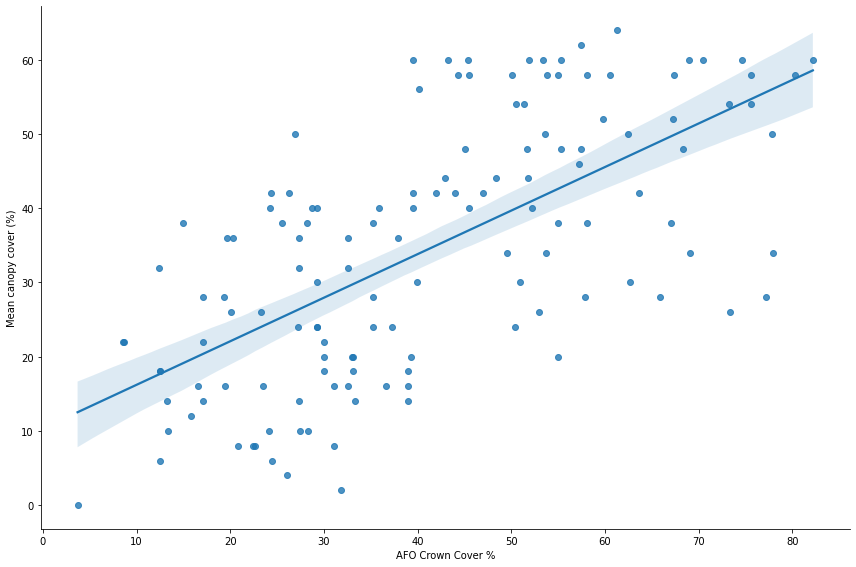

other stats:
pearson r: 0.48 	 r sq: 0.23 	 p: 0.16
pilliga stats:
pearson r: -0.26 	 r sq: 0.07 	 p: 0.16
central stats:
pearson r: 0.38 	 r sq: 0.15 	 p: 0.02
snowy stats:
pearson r: 0.76 	 r sq: 0.57 	 p: 0.00


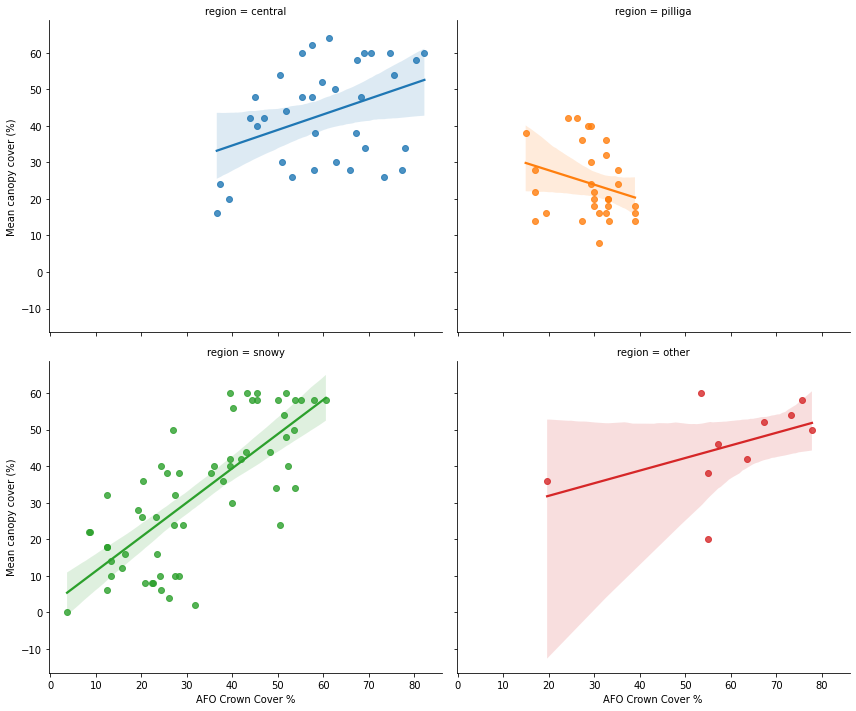

DSF stats:
pearson r: 0.64 	 r sq: 0.41 	 p: 0.00
WSF stats:
pearson r: 0.43 	 r sq: 0.18 	 p: 0.08


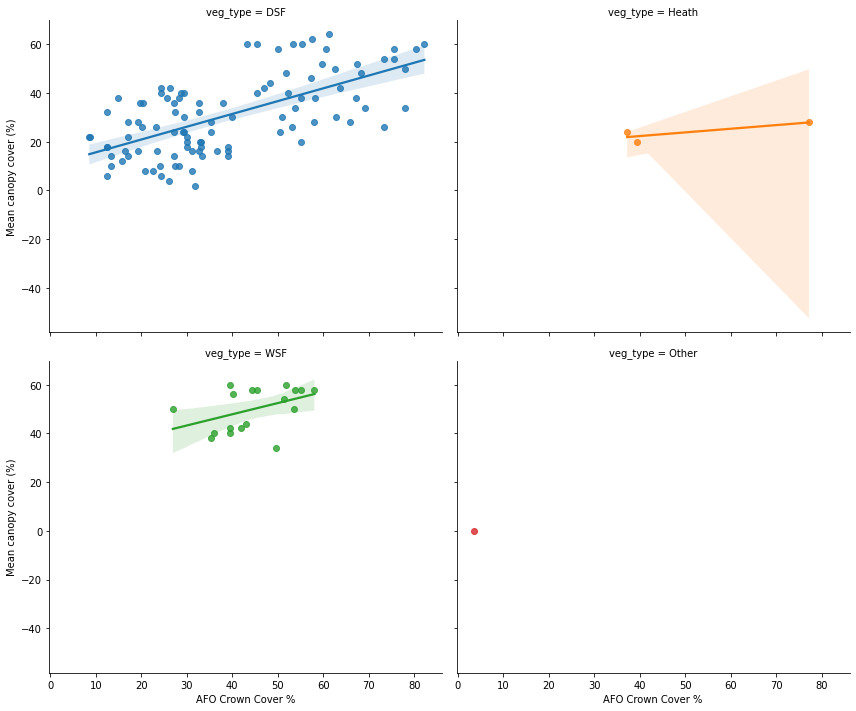

In [395]:
x = 'afo_cc'
y = 'canopy_cov_m'
df = gdf_z56
reg_plot(x, y, df)
plt.show()
reg_plots(x, y, df)
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

AFO Crown Cover % v Mean elevated height (m)
stats:
pearson r: 0.38 	 r sq: 0.15 	 p: 0.01


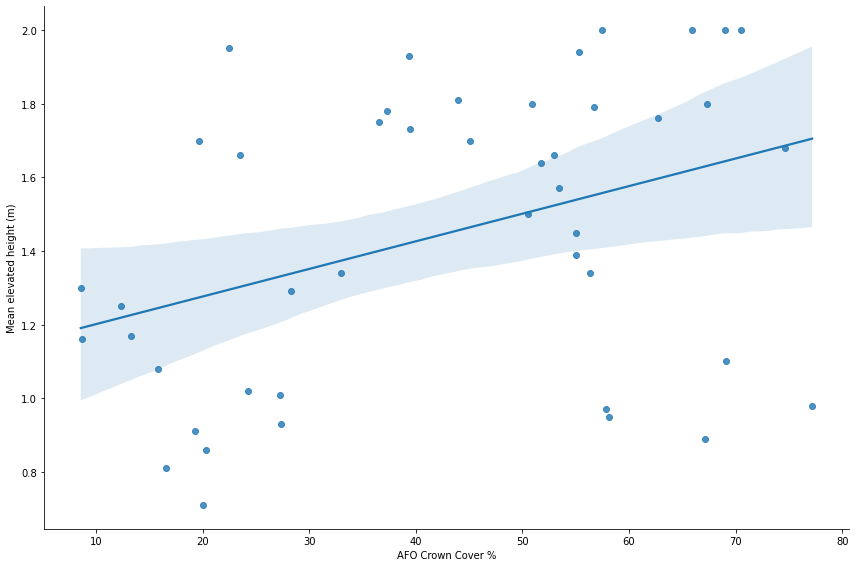

central stats:
pearson r: -0.28 	 r sq: 0.08 	 p: 0.20
snowy stats:
pearson r: 0.27 	 r sq: 0.08 	 p: 0.30


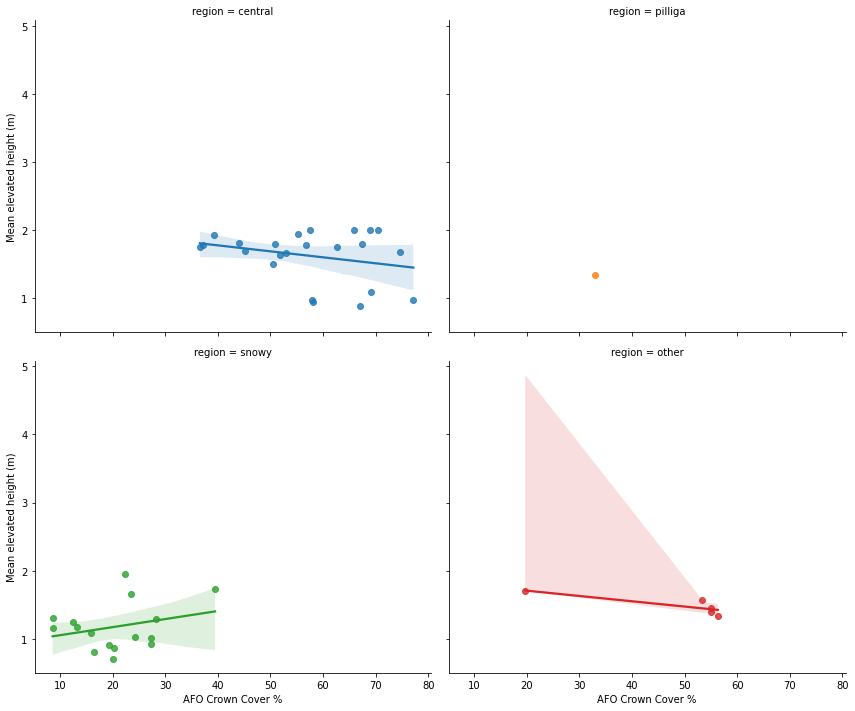

DSF stats:
pearson r: 0.33 	 r sq: 0.11 	 p: 0.08


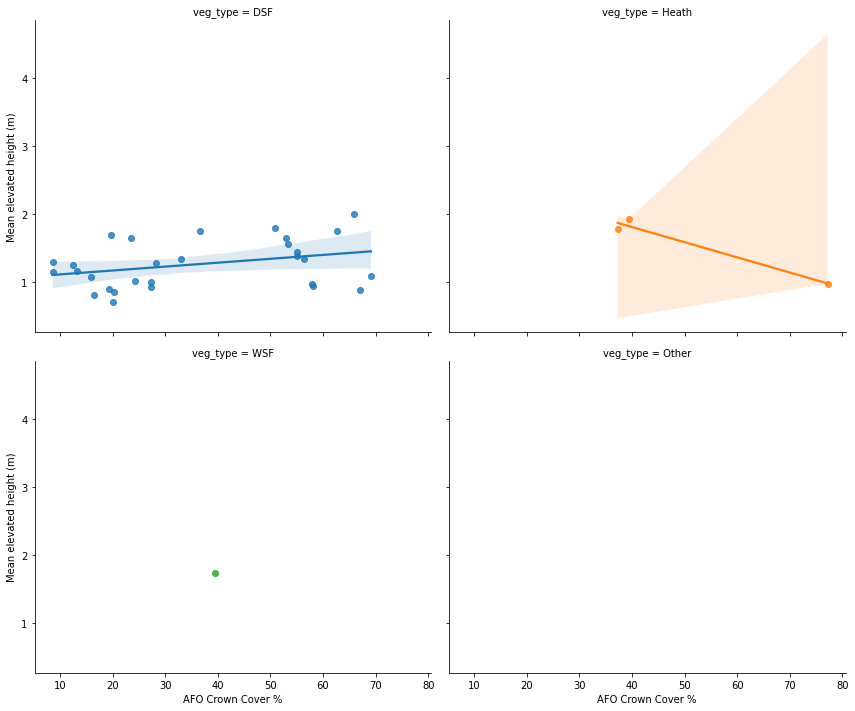

In [396]:
x = 'afo_cc'
y = 'elev_h_m'
df = gdf_z56
reg_plot(x, y, df)
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

In [417]:
_gdf = gpd.read_file('spatial_data/Field_Data/Fuel_Sampling___Version_0_1.shp')
_gdf = _gdf.rename(columns=rename_dict)

In [418]:
print(sorted(list(_gdf.columns.values)))

['CreationDa', 'Creator', 'EditDate', 'Editor', 'WHS', '_elev_fhr', '_ns_fhr', 'bark_haz', 'bark_haz&type', 'bark_load', 'bark_type', 'canopy_cov_1', 'canopy_cov_3', 'canopy_cov_5', 'canopy_cov_7', 'canopy_cov_9', 'canopy_cov_m', 'canopy_h_1', 'canopy_h_3', 'canopy_h_5', 'canopy_h_7', 'canopy_h_9', 'canopy_h_m', 'check', 'comments', 'date', 'deviceid', 'elev_cov', 'elev_dead_%', 'elev_dead_count', 'elev_fhr', 'elev_h_1', 'elev_h_10', 'elev_h_2', 'elev_h_3', 'elev_h_4', 'elev_h_5', 'elev_h_6', 'elev_h_7', 'elev_h_8', 'elev_h_9', 'elev_h_m', 'elev_load', 'elev_state_1', 'elev_state_10', 'elev_state_2', 'elev_state_3', 'elev_state_4', 'elev_state_5', 'elev_state_6', 'elev_state_7', 'elev_state_8', 'elev_state_9', 'elev_state_count', 'endsurvey', 'fire_hist', 'generals', 'geometry', 'id', 'lat', 'litter_cov', 'litter_cov_count', 'litter_d_1', 'litter_d_10', 'litter_d_2', 'litter_d_3', 'litter_d_4', 'litter_d_5', 'litter_d_6', 'litter_d_7', 'litter_d_8', 'litter_d_9', 'litter_d_m', 'litter_

In [415]:
elev_h = [s for s in list(_gdf.columns.values) if 'elev_h' in s]
_gdf['_mean'] = _gdf[elev_h[:-1]].mean(axis=1)
elev_h.append('_mean')
_gdf[elev_h]

,elev_h_1,elev_h_2,elev_h_3,elev_h_4,elev_h_5,elev_h_6,elev_h_7,elev_h_8,elev_h_9,elev_h_10,elev_h_m,_mean
0,0.0,0.0,0.0,0.0,0.7,0.0,2.0,0.0,0.0,1.6,None,0.43
1,1.8,0.5,2.0,2.0,2.0,2.0,2.0,2.0,1.5,2.0,1.78,1.78
2,0.0,1.6,1.7,0.0,0.0,0.0,0.0,0.6,0.0,0.0,None,0.39
3,2.0,2.0,1.5,1.7,1.6,1.6,2.0,1.9,1.8,1.8,1.7900000000000003,1.79
4,1.5,1.1,1.2,0.9,1.1,0.9,0.8,1.0,0.7,0.6,0.9799999999999999,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...
138,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2,2.00
139,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2,2.00
140,1.6,1.7,1.6,1.7,1.8,1.6,1.8,1.6,1.6,1.8,1.6800000000000002,1.68
141,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.8,1.9,1.7,1.94,1.94


In [403]:
temp = field_gdf[['site', 'plot', 'elev_h_m']].loc[field_gdf['site'].str.startswith('P')].dropna()

,site,plot,elev_h_m
38,P1,3,1.34
